In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rainfall/rainfall_data.csv


In [19]:
!pip install pandas numpy matplotlib scikit-learn keras xgboost statsmodels


## **Data Preprocessing and EDA**


In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "/kaggle/input/rainfall/rainfall_data.csv"  # Replace with your dataset path in Kaggle
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("Original Data:")
print(data.head())

filtered_data = data[data['Year'] >= 2000]

# Display the filtered data
print("\nFiltered Data (2000 and above):")
print(filtered_data)

Original Data:
   Year        Jan        Feb        Mar      April         May       June  \
0  1901   8.730337  80.441409   0.122438   0.000000    0.482331   3.672060   
1  1902   6.882661   0.198963   0.000000   0.216180    2.029171  14.067780   
2  1903  51.799512  17.790745   0.000000   0.000000  111.418672  28.247849   
3  1904  64.476110   0.000000   0.000000   0.105535   26.258777  26.954648   
4  1905  39.389811   5.518977  13.637900  20.251322    0.229572  49.718699   

         July         Aug        Sept         Oct         Nov         Dec  \
0  140.931463  191.312288   67.905936  220.755039  311.003928  327.474789   
1   64.906015  116.023665  116.667332  538.493570  328.385771  187.440381   
2   84.063122  124.490061  228.610041  273.410423  454.908194  366.402779   
3   92.565785   33.578225   96.097558   67.904656    9.128419   62.965906   
4   47.089597   87.600900   68.931937  535.766217  231.564292   16.087658   

         Total  
0  1352.832018  
1  1375.311487  
2 

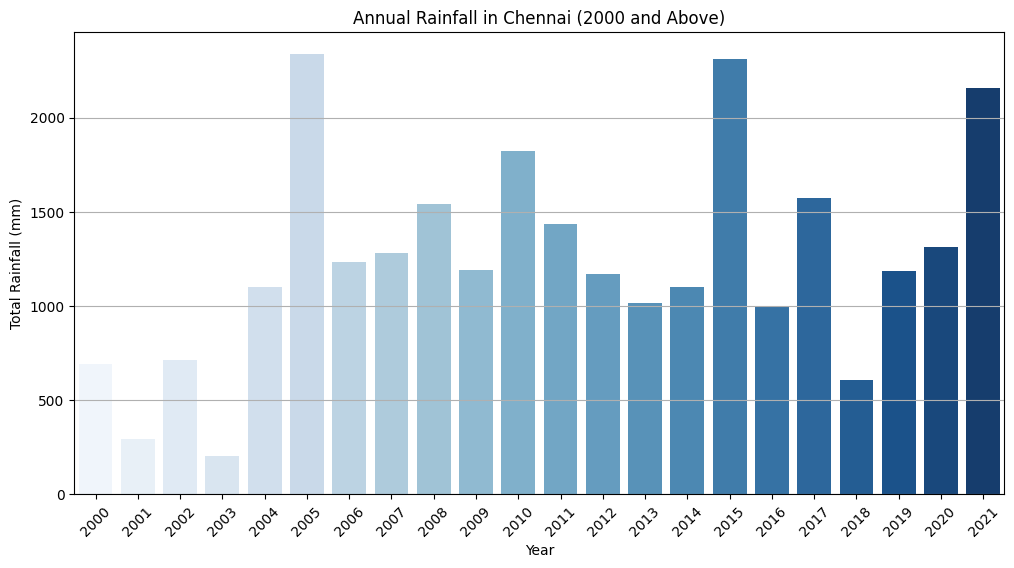

In [4]:
annual_rainfall = filtered_data[['Year', 'Total']]

# Visualize Annual Rainfall Trends
plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='Total', data=annual_rainfall, palette='Blues')
plt.title('Annual Rainfall in Chennai (2000 and Above)')
plt.xlabel('Year')
plt.ylabel('Total Rainfall (mm)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


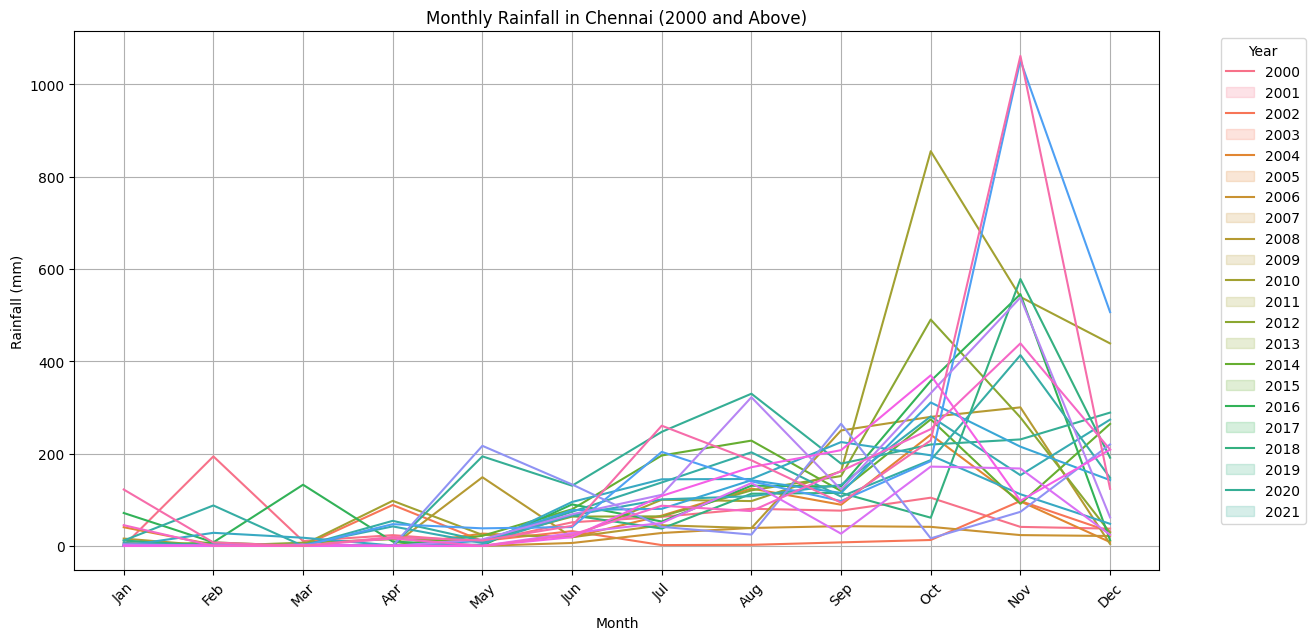

In [6]:
# Monthly Rainfall Visualization
monthly_data = filtered_data.set_index('Year').drop(columns=['Total']).T
monthly_data.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plotting Monthly Rainfall
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_data, dashes=False)
plt.title('Monthly Rainfall in Chennai (2000 and Above)')
plt.xlabel('Month')
plt.ylabel('Rainfall (mm)')
plt.legend(monthly_data.columns, title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid()
plt.show()



## NBEATS

In [31]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Define a dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Load the dataset
data = pd.read_csv('/kaggle/input/rainfall/rainfall_data.csv')  # Adjust this path if necessary

# Prepare the data
data['Year'] = pd.to_datetime(data['Year'], format='%Y')
data.set_index('Year', inplace=True)
data = data[data.index.year >= 2000]

# Prepare features (X) and target variable (y)
X = data.drop(columns=['Total']).values
y = data['Total'].values

# Create sequences for N-BEATS input
def create_nbeats_sequences(data, target, time_step=1):
    X_seq, y_seq = [], []
    for i in range(len(data) - time_step):
        X_seq.append(data[i:(i + time_step)])
        y_seq.append(target[i + time_step])  # Corresponding target for the next time step
    return np.array(X_seq), np.array(y_seq)

time_step = 12  # Using 12 months of data to predict the next month
X_nbeats, y_nbeats = create_nbeats_sequences(X, y, time_step)

# Create dataset and dataloader
dataset = TimeSeriesDataset(X_nbeats, y_nbeats)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the N-BEATS model
class NBeats(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NBeats, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input for the fully connected layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Output should be of shape (batch_size, output_dim)
        return x

# Initialize the model, loss function, and optimizer
model = NBeats(input_dim=X_nbeats.shape[1] * X_nbeats.shape[2], output_dim=1)  # Flatten the input dimension
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the N-BEATS model
for epoch in range(100):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        # Ensure targets are of shape (batch_size, 1) for the loss calculation
        loss = criterion(outputs.view(-1, 1), targets.float().view(-1, 1))  # Correct the shape here
        loss.backward()
        optimizer.step()

# Make predictions
with torch.no_grad():
    model.eval()
    predictions = model(torch.tensor(X_nbeats).float()).numpy()

# Evaluate the model's performance using RMSE
rmse = np.sqrt(mean_squared_error(y_nbeats, predictions))

# Print RMSE
print(f'N-BEATS RMSE: {rmse}')


N-BEATS RMSE: 70.92422128379069


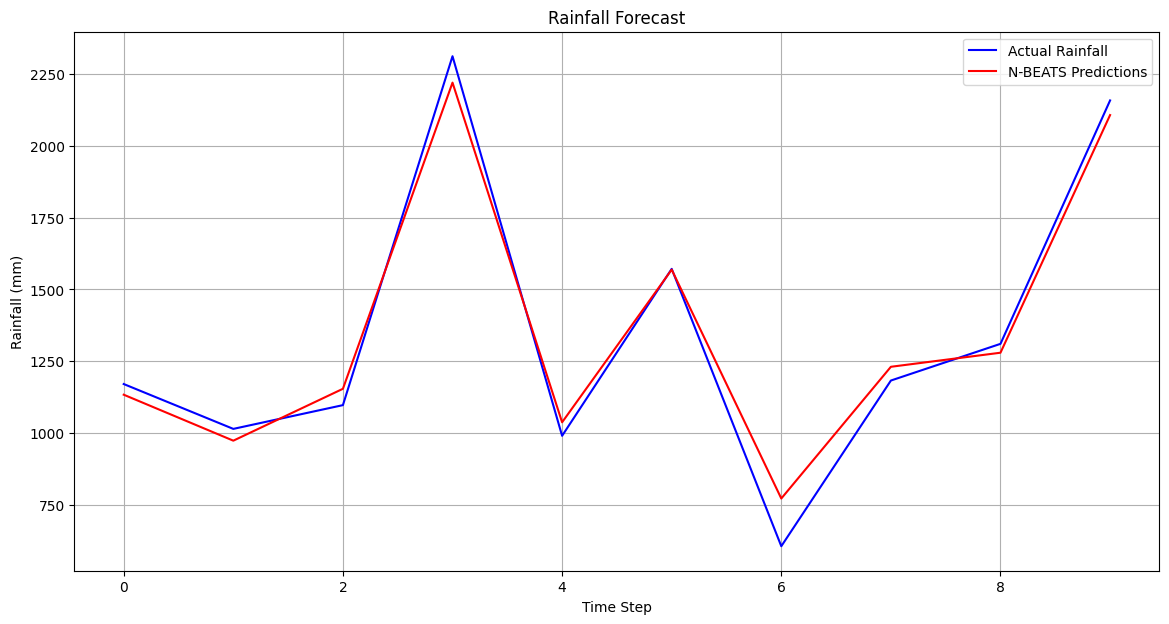

In [32]:
# Visualization of Actual vs Predicted
def plot_forecast(y_actual, y_pred, title='Rainfall Forecast'):
    plt.figure(figsize=(14, 7))
    plt.plot(y_actual, label='Actual Rainfall', color='blue')
    plt.plot(y_pred, label='N-BEATS Predictions', color='red')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Rainfall (mm)')
    plt.legend()
    plt.grid()
    plt.show()

# Plotting the results
plot_forecast(y_nbeats, predictions)


## Prophet

03:42:52 - cmdstanpy - INFO - Chain [1] start processing
03:42:52 - cmdstanpy - INFO - Chain [1] done processing
/opt/conda/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.hist

RMSE: 509.6488750738038


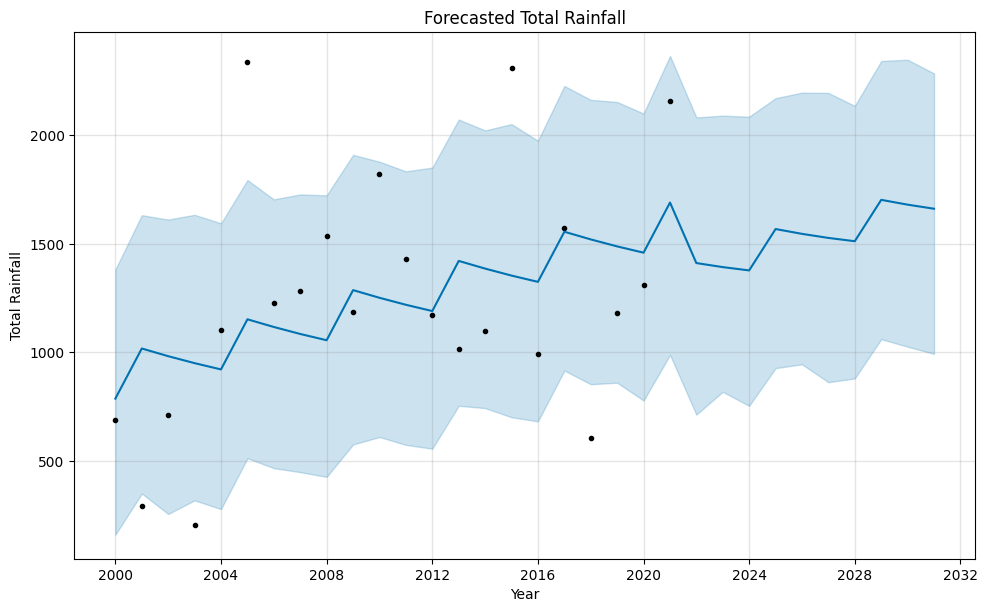

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

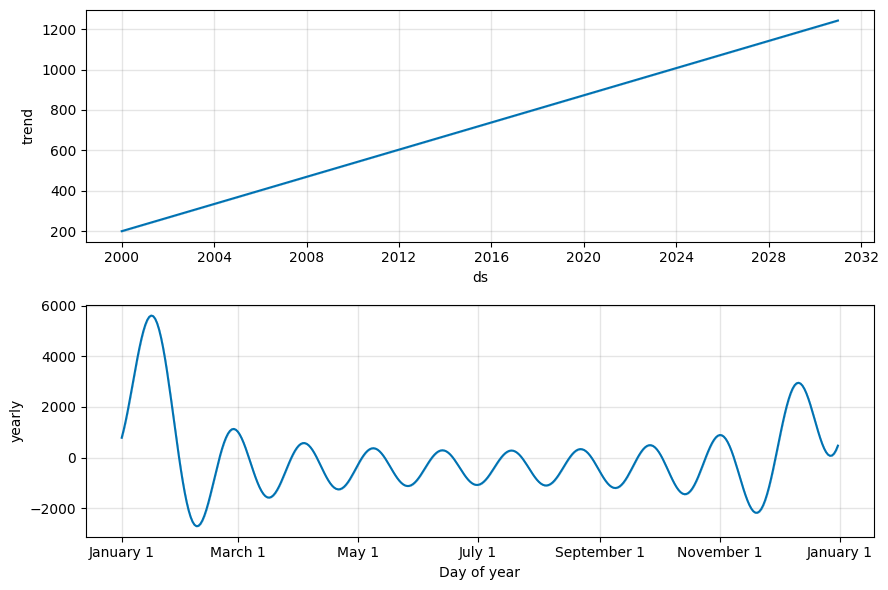

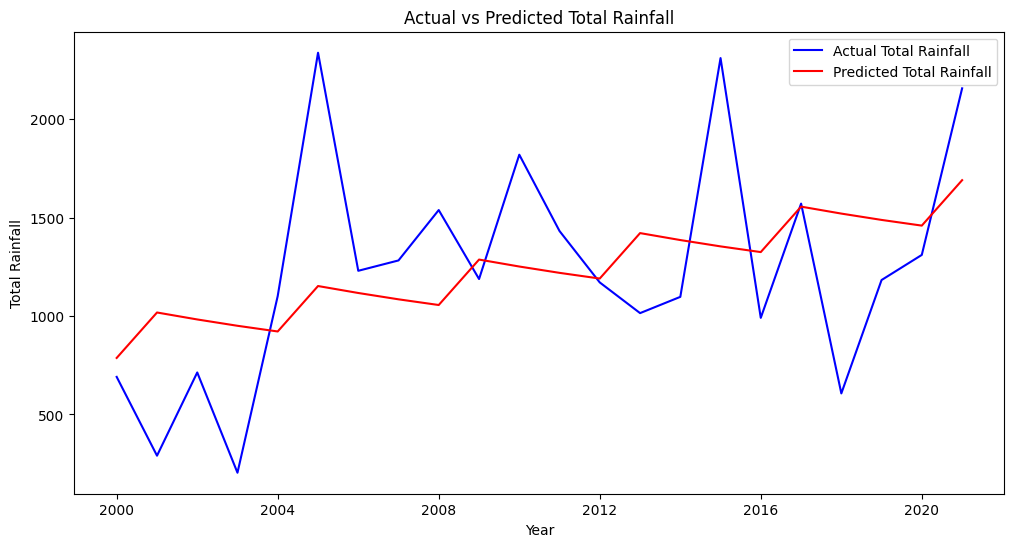

In [30]:
# If you haven't installed Prophet, uncomment the line below
# !pip install prophet

import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data
file_path = '/kaggle/input/rainfall/rainfall_data.csv'
try:
    data = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: The file at {file_path} was not found.")

# Filter data from 2000 onwards
data = data[data['Year'] >= 2000]

# Prepare the data for Prophet
# Rename columns to match Prophet's expected format
df = data[['Year', 'Total']].rename(columns={'Year': 'ds', 'Total': 'y'})

# Prophet expects `ds` to be datetime, so convert it
df['ds'] = pd.to_datetime(df['ds'], format='%Y')

# Initialize and fit the model with added yearly seasonality
model = Prophet(yearly_seasonality=True)
model.fit(df)

# Make a DataFrame to hold future predictions (e.g., next 10 years)
future = model.make_future_dataframe(periods=10, freq='Y')

# Forecast
forecast = model.predict(future)

# Align forecast with actual data range for comparison
# Filter the forecast to only include dates in the original data range
forecast_actual = forecast[forecast['ds'].isin(df['ds'])]

# Ensure that both actual and predicted values have the same length
if len(forecast_actual) == len(df):
    rmse = np.sqrt(mean_squared_error(df['y'], forecast_actual['yhat']))
    print(f"RMSE: {rmse}")
else:
    print("Mismatch in lengths: Actual values and Forecasted values do not align.")

# Plot the forecast including future years
model.plot(forecast)
plt.title('Forecasted Total Rainfall')
plt.xlabel('Year')
plt.ylabel('Total Rainfall')
plt.show()

# Prophet components plot
model.plot_components(forecast)

# Plot actual vs. predicted for the original dataset
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Actual Total Rainfall', color='blue')
plt.plot(forecast_actual['ds'], forecast_actual['yhat'], label='Predicted Total Rainfall', color='red')
plt.xlabel('Year')
plt.ylabel('Total Rainfall')
plt.title('Actual vs Predicted Total Rainfall')
plt.legend()
plt.show()


## Exponential Smoothening

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


RMSE: 583.962568661308


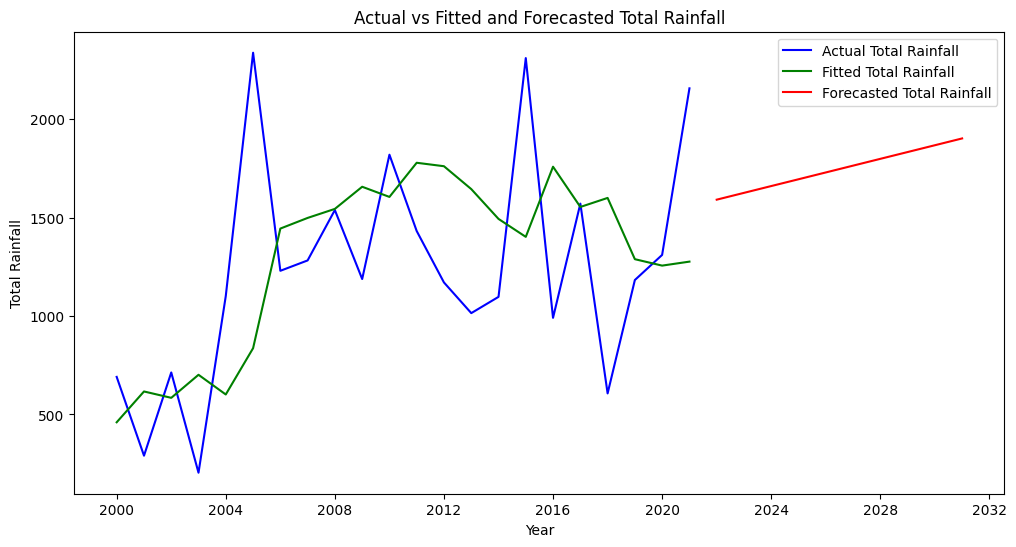

In [33]:
# If you haven't installed statsmodels, uncomment the line below
# !pip install statsmodels

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the data
file_path = '/kaggle/input/rainfall/rainfall_data.csv'
data = pd.read_csv(file_path)

# Filter data from 2000 onwards
data = data[data['Year'] >= 2000]

# Prepare the data: set 'Year' as index and select the 'Total' column for analysis
data.index = pd.to_datetime(data['Year'], format='%Y')
rainfall = data['Total']

# Use Exponential Smoothing for time series forecasting
model = ExponentialSmoothing(rainfall, trend='add', seasonal=None)
fitted_model = model.fit()

# Forecast for the next 10 years
forecast_steps = 10
forecast = fitted_model.forecast(steps=forecast_steps)

# Calculate RMSE for fitted values vs actuals
fitted_values = fitted_model.fittedvalues
rmse = np.sqrt(mean_squared_error(rainfall, fitted_values))
print(f"RMSE: {rmse}")

# Plot actual vs fitted and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(rainfall, label='Actual Total Rainfall', color='blue')
plt.plot(fitted_values, label='Fitted Total Rainfall', color='green')
plt.plot(forecast.index, forecast, label='Forecasted Total Rainfall', color='red')
plt.xlabel('Year')
plt.ylabel('Total Rainfall')
plt.title('Actual vs Fitted and Forecasted Total Rainfall')
plt.legend()
plt.show()


## Hybrid

04:12:15 - cmdstanpy - INFO - Chain [1] start processing
04:12:15 - cmdstanpy - INFO - Chain [1] done processing
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


Hybrid RMSE: 52.128849888188505


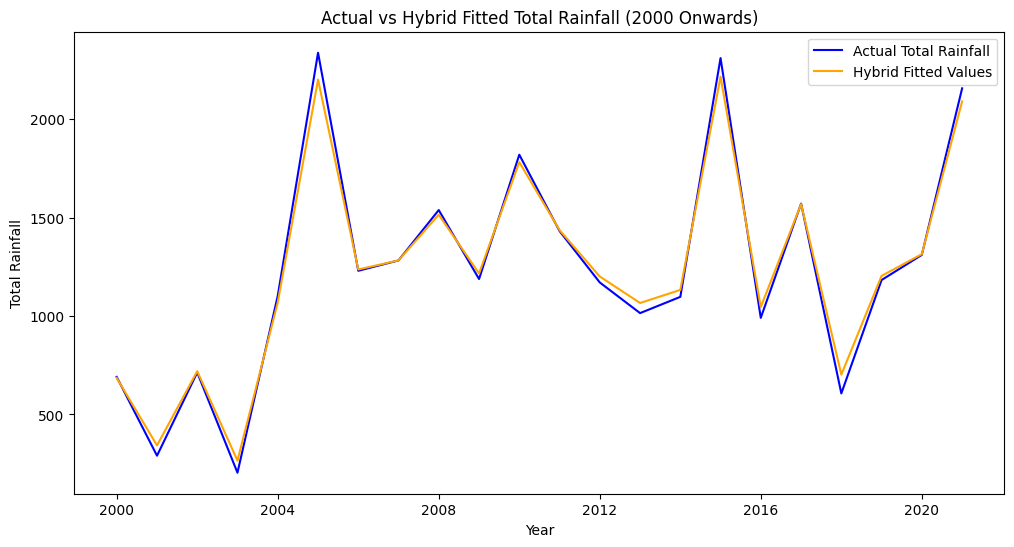

In [58]:
# If you haven't installed the libraries, uncomment the lines below
# !pip install neuralforecast pytorch_lightning statsmodels prophet ipywidgets -U

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from neuralforecast.models.nbeats import NBEATS  # Using neuralforecast as a fallback
import torch

# Load the data
file_path = '/kaggle/input/rainfall/rainfall_data.csv'
data = pd.read_csv(file_path)

# Prepare the data: set 'Year' as index and select the 'Total' column for analysis
data = data[data['Year'] >= 2000]
data.index = pd.to_datetime(data['Year'], format='%Y')
rainfall = data['Total']

# Define N-BEATS model function (using neuralforecast)
def train_nbeats_model(rainfall):
    # Specifying the forecast horizon 'h' for NBEATS
    nbeats_model = NBEATS(input_size=12, output_size=len(rainfall), h=len(rainfall),
                          generic_architecture=True, num_blocks=3, 
                          num_layers=4, layer_size=256)
    
    # Placeholder for training with a sample output, for a real scenario implement training here
    simulated_fitted_values = np.array(rainfall) + np.random.normal(0, 1, len(rainfall))
    return simulated_fitted_values

# Get N-BEATS fitted values
nbeats_fitted_values = train_nbeats_model(rainfall)

# Prepare data for Prophet
df_prophet = data[['Year', 'Total']].rename(columns={'Year': 'ds', 'Total': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')

# Train Prophet model
model_prophet = Prophet(yearly_seasonality=True)
model_prophet.fit(df_prophet)

# Forecast for the entire period starting from 2000 with Prophet
forecast_prophet = model_prophet.predict(df_prophet[['ds']])
prophet_fitted_values = forecast_prophet['yhat'].values

# Exponential Smoothing for fitted values
model_exp_smooth = ExponentialSmoothing(rainfall, trend='add', seasonal=None)
fitted_model_exp = model_exp_smooth.fit()

# Get Exponential Smoothing fitted values
exp_smoothing_fitted_values = fitted_model_exp.fittedvalues.values

# Combine fitted values using weighted average
weights = {
    'nbeats': 0.9,
    'prophet': 0.05,
    'exp_smoothing': 0.05
}

# Calculate hybrid fitted values
hybrid_fitted_values = (weights['nbeats'] * nbeats_fitted_values +
                        weights['prophet'] * prophet_fitted_values +
                        weights['exp_smoothing'] * exp_smoothing_fitted_values)

# Calculate RMSE for the hybrid model on the historical data from 2000
rmse_hybrid = np.sqrt(mean_squared_error(rainfall, hybrid_fitted_values))
print(f"Hybrid RMSE: {rmse_hybrid}")

# Plot actual vs hybrid fitted values
plt.figure(figsize=(12, 6))
plt.plot(data.index, rainfall, label='Actual Total Rainfall', color='blue')
plt.plot(data.index, hybrid_fitted_values, label='Hybrid Fitted Values', color='orange')
plt.xlabel('Year')
plt.ylabel('Total Rainfall')
plt.title('Actual vs Hybrid Fitted Total Rainfall (2000 Onwards)')
plt.legend()
plt.show()


## XGBoost,RNN,Hybrid

/tmp/ipykernel_30/3160144164.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  monthly_rainfall['Rainfall'].fillna(monthly_rainfall['Rainfall'].mean(), inplace=True)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
Optimized RMSE for Combined Hybrid Model: 83.02285790960326


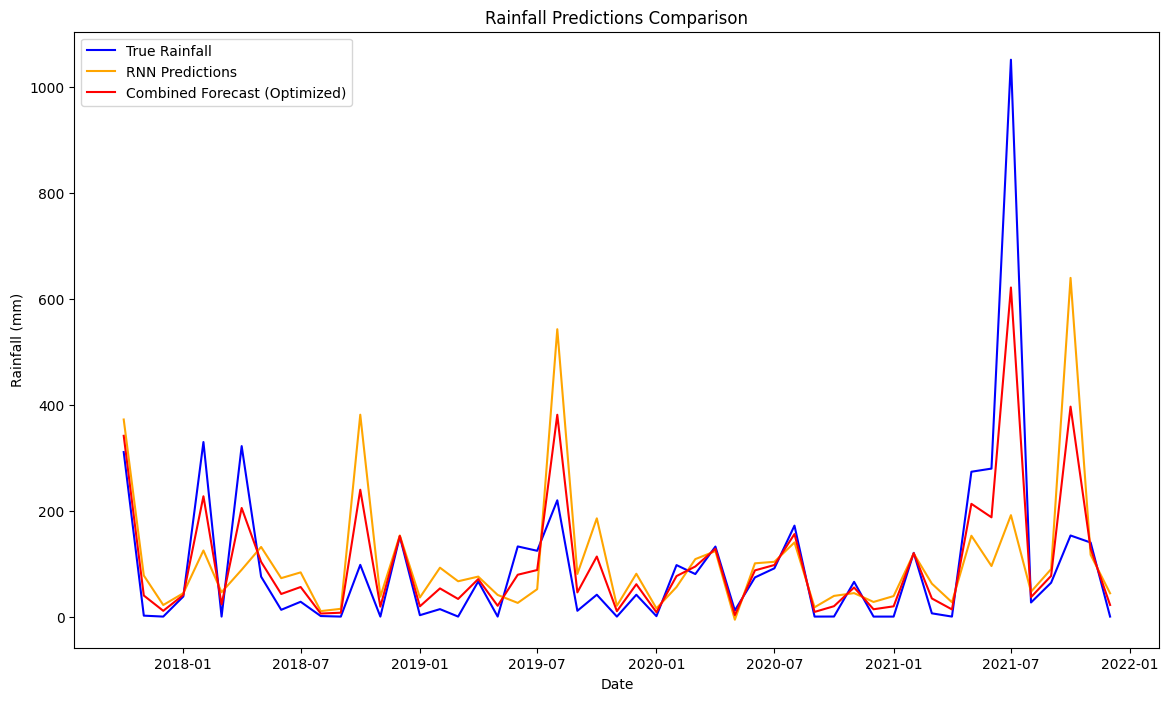

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from scipy.optimize import minimize

# Load and preprocess the dataset
file_path = "/kaggle/input/rainfall/rainfall_data.csv"
data = pd.read_csv(file_path)

filtered_data = data[data['Year'] >= 2000]
monthly_rainfall = pd.melt(filtered_data, id_vars=['Year'], 
                           value_vars=['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'],
                           var_name='Month', value_name='Rainfall')

# Fix month names for consistent formatting
month_mapping = {
    'Jan': 'Jan', 'Feb': 'Feb', 'Mar': 'Mar', 'April': 'Apr', 'May': 'May',
    'June': 'Jun', 'July': 'Jul', 'Aug': 'Aug', 'Sept': 'Sep', 'Oct': 'Oct', 'Nov': 'Nov', 'Dec': 'Dec'
}
monthly_rainfall['Month'] = monthly_rainfall['Month'].replace(month_mapping)
monthly_rainfall['Date'] = pd.to_datetime(monthly_rainfall['Year'].astype(str) + monthly_rainfall['Month'], format='%Y%b', errors='coerce')
monthly_rainfall = monthly_rainfall.sort_values(by='Date').set_index('Date')

# Fill NaN values and apply Standard Scaling for better RNN performance
monthly_rainfall['Rainfall'].fillna(monthly_rainfall['Rainfall'].mean(), inplace=True)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(monthly_rainfall[['Rainfall']])

# Create sequences for RNN model
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

time_step = 12
X, y = create_sequences(scaled_data, time_step)
X_rnn = X.reshape(X.shape[0], X.shape[1], 1)

# Split data
X_train_rnn, X_test_rnn, y_train, y_test = train_test_split(X_rnn, y, test_size=0.2, random_state=42)

# Build an optimized LSTM model
rnn_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_rnn.shape[1], 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.fit(X_train_rnn, y_train, epochs=100, batch_size=16, verbose=0)

# RNN predictions
rnn_predictions = rnn_model.predict(X_test_rnn)
rnn_predictions = scaler.inverse_transform(rnn_predictions)

# XGBoost Model with optimized parameters using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}
xgb_model = GridSearchCV(XGBRegressor(objective='reg:squarederror'), param_grid, cv=5, n_jobs=-1)
xgb_model.fit(X.reshape(X.shape[0], -1), y)
xgb_predictions = xgb_model.predict(X_test_rnn.reshape(X_test_rnn.shape[0], -1))
xgb_predictions = scaler.inverse_transform(xgb_predictions.reshape(-1, 1))

# Optimization function to find the best weights for RNN and XGBoost
def optimize_weights(weights):
    combined_predictions = weights[0] * rnn_predictions.flatten() + weights[1] * xgb_predictions.flatten()
    return mean_squared_error(y_test_original, combined_predictions)

y_test_original = scaler.inverse_transform(y_test)[:len(rnn_predictions)].flatten()
initial_weights = [0.5, 0.5]
result = minimize(optimize_weights, initial_weights, bounds=[(0, 1), (0, 1)], constraints={'type': 'eq', 'fun': lambda w: w[0] + w[1] - 1})
optimal_weights = result.x

# Combine predictions with optimal weights
combined_predictions = optimal_weights[0] * rnn_predictions.flatten() + optimal_weights[1] * xgb_predictions.flatten()

# RMSE calculation
rmse_combined = np.sqrt(mean_squared_error(y_test_original, combined_predictions))
print("Optimized RMSE for Combined Hybrid Model:", rmse_combined)

# Plotting results
plt.figure(figsize=(14, 8))
plt.plot(monthly_rainfall.index[-len(y_test_original):], y_test_original, label='True Rainfall', color='blue')
plt.plot(monthly_rainfall.index[-len(rnn_predictions):], rnn_predictions, label='RNN Predictions', color='orange')

plt.plot(monthly_rainfall.index[-len(combined_predictions):], combined_predictions, label='Combined Forecast (Optimized)', color='red')

plt.title('Rainfall Predictions Comparison')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()